### exp: eqtl prediction, slope prediction, gpn for machine learning

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
model_size = ['small','middle','large']
model_list = ['MLP', 'CNN', 'RNN']
tissue = 'Nerve_Tibial'
data_path = '../../../../../datasets_embedding/gpn/eqtl_datasets/slope_prediction/' + tissue + '/'
image_path = 'images_seed1030/'
# set seed
seed = 1030
import random
random.seed(seed)
np.random.seed(seed)

#### small model

In [3]:
model = model_size[0]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['gpn_before'][i].flatten().tolist()
    feature_list += train_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['gpn_before'][i].flatten().tolist()
    feature_list += test_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0   ENSG00000242485.5   chr1_1407232_G_C_b38           -81  0.182648   
1  ENSG00000157881.13   chr1_2526571_G_C_b38           -57  0.020548   
2   ENSG00000231789.2   chr1_9687685_C_T_b38           130  0.043379   
3   ENSG00000272084.1  chr1_19075748_C_A_b38           237  0.109589   
4   ENSG00000090432.6  chr1_20508117_C_A_b38           -44  0.110599   

  ma_samples ma_count  pval_nominal     slope  slope_se  \
0        147      160  3.926291e-46  0.436504  0.026472   
1         17       18  5.059731e-09  0.500525  0.083591   
2         36       38  1.409246e-08  0.738330  0.127241   
3         91       96  7.632423e-09  0.404185  0.068344   
4         93       96  3.275938e-73  0.996535  0.043319   

                                          seq_before  \
0  gcactccagcctgggtgacagcgcgagactccgtctcggggtaaga...   
1  cgaaaagggagtaattcgcgttcctcccctagaggtggctgggagg...   
2  tgtggcccaggctggtcttgaactcctgggctcaagtgatc

##### model 1: mlp

rmse= 0.7049989554197992
r2= 0.007862978202012538
pcc= 0.17083500464277696
pcc_p= 0.22130848774866085


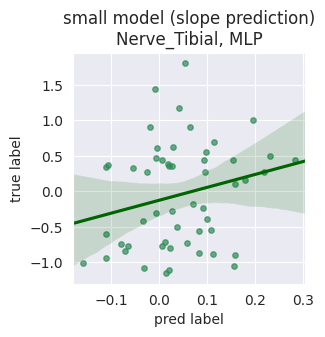

In [4]:
# model 1: mlp
from sklearn.neural_network import MLPRegressor
ml_model = model_list[0]
mlp = MLPRegressor(max_iter=1000, early_stopping=True, learning_rate_init=0.001, hidden_layer_sizes=(1024, 512, 128))

mlp.fit(X_train,Y_train)

y_pred = mlp.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:cnn

2024-11-06 22:08:49.448612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 22:08:49.461601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 22:08:49.465270: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 22:08:49.475391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06 22:08:50.191775: W tensorflow/comp

rmse= 0.7199669788264437
r2= -0.03471290290142193
pcc= 0.06962325950683695
pcc_p= 0.6203315485171021


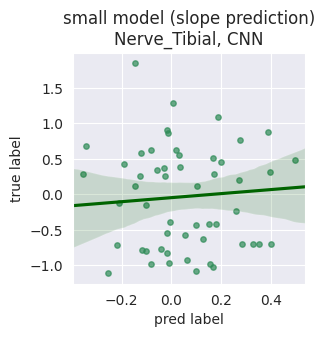

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


def build_model(n_layers=1, kernel_size=3, strides=1, filters=16, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(1024, 1)))
    model.add(layers.MaxPool1D(2, padding='same'))
    if n_layers == 2:
        # 如果有两层，添加第二层卷积层
        model.add(layers.Conv1D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'))
        model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

    return model

X_train_reshape = np.expand_dims(X_train, axis=-1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ml_model = model_list[1]
# cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=5, strides=1, filters=16, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)
cnn = KerasRegressor(model=build_model, n_layers=2, kernel_size=3, strides=1, filters=16,learning_rate=0.001, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

cnn.fit(X_train_reshape, Y_train, batch_size=16, callbacks=[early_stopping])

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_pred = cnn.predict(X_test_reshape)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: rnn

rmse= 0.7793948413174338
r2= -0.21257821806577137
pcc= -0.04928706324698065
pcc_p= 0.7259842601018361


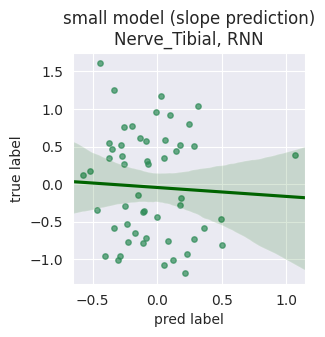

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def build_model(units, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.SimpleRNN(units=units, return_sequences=True, input_shape=(1024, 1)))
    model.add(layers.Flatten(input_shape=(1024, units)))
    model.add(layers.Dense(1))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
    return model

ml_model = model_list[2]

# 早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 定义模型
rnn = KerasRegressor(model=build_model, units=8, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

X_train_reshape = np.expand_dims(X_train, axis=-1)

# 执行网格搜索
rnn.fit(X_train_reshape,Y_train, verbose=0)

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_pred = rnn.predict(X_test_reshape)

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#2E8B57','alpha':0.7,'s':15}, line_kws={"color": "#006400"},truncate=False)
plt.title('small model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-small-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### middle model

In [7]:
model = model_size[1]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['gpn_before'][i].flatten().tolist()
    feature_list += train_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['gpn_before'][i].flatten().tolist()
    feature_list += test_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id            variant_id  tss_distance       maf  \
0   ENSG00000272512.1   chr1_989148_C_A_b38         -8903  0.455742   
1   ENSG00000272512.1   chr1_999842_C_A_b38          1791  0.444064   
2  ENSG00000008128.22  chr1_1733506_G_A_b38          9182  0.013699   
3  ENSG00000008130.15  chr1_1777680_C_T_b38         -2777  0.076484   
4   ENSG00000182873.5  chr1_2189679_C_T_b38          5290  0.378995   

  ma_samples ma_count  pval_nominal     slope  slope_se  \
0        315      400  6.301756e-45  0.753825  0.046540   
1        301      389  2.103221e-49  0.757170  0.043822   
2         12       12  2.895097e-10  1.414804  0.218233   
3         66       67  3.749908e-13  0.248043  0.032905   
4        276      332  4.958885e-20  0.558117  0.057414   

                                          seq_before  \
0  cttccttttaatgaagtctaatttgcccatttttcttgatgtatta...   
1  cttccttttaatgaagtctaatttgcccatttttcttgatgtatta...   
2  ttcagaatggataatttctactgctccatccacaagttgtttccaa.

##### model 1: mlp

rmse= 0.8296130482280991
r2= -0.08211209838633438
pcc= -0.03264704587778552
pcc_p= 0.7946881923077327


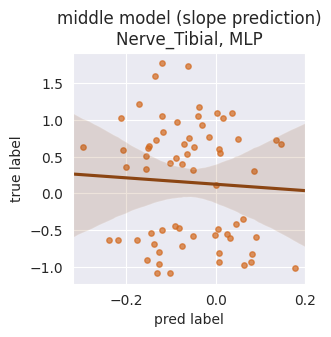

In [8]:
from sklearn.neural_network import MLPRegressor
ml_model = model_list[0]
mlp = MLPRegressor(max_iter=1000, early_stopping=True, learning_rate_init=0.001, hidden_layer_sizes=(1024, 512, 128))

mlp.fit(X_train,Y_train)

y_pred = mlp.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:cnn

rmse= 0.821054528102247
r2= -0.059900521013423136
pcc= 0.057206321696469005
pcc_p= 0.6482170078126633


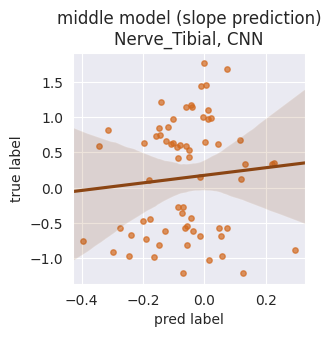

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


def build_model(n_layers=1, kernel_size=3, strides=1, filters=16, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(1024, 1)))
    model.add(layers.MaxPool1D(2, padding='same'))
    if n_layers == 2:
        # 如果有两层，添加第二层卷积层
        model.add(layers.Conv1D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'))
        model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

    return model

X_train_reshape = np.expand_dims(X_train, axis=-1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ml_model = model_list[1]
# cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=5, strides=1, filters=16, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)
cnn = KerasRegressor(model=build_model, n_layers=2, kernel_size=3, strides=1, filters=16,learning_rate=0.001, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

cnn.fit(X_train_reshape, Y_train, batch_size=16, callbacks=[early_stopping])

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_pred = cnn.predict(X_test_reshape)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: rnn

rmse= 0.850672458408667
r2= -0.13774739265156377
pcc= -0.20149647096870196
pcc_p= 0.10472282428584462


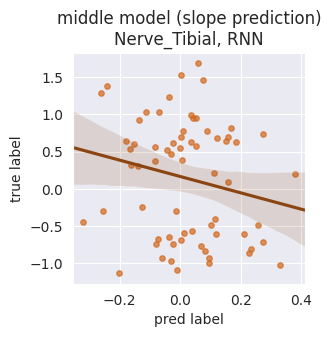

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def build_model(units, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.SimpleRNN(units=units, return_sequences=True, input_shape=(1024, 1)))
    model.add(layers.Flatten(input_shape=(1024, units)))
    model.add(layers.Dense(1))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
    return model

ml_model = model_list[2]

# 早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 定义模型
rnn = KerasRegressor(model=build_model, units=8, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

X_train_reshape = np.expand_dims(X_train, axis=-1)

# 执行网格搜索
rnn.fit(X_train_reshape,Y_train, verbose=0)

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_pred = rnn.predict(X_test_reshape)

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#D2691E','alpha':0.7,'s':15}, line_kws={"color": "#8B4513"},truncate=False)
plt.title('middle model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-middle-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### large model

In [11]:
model = model_size[2]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['gpn_before'][i].flatten().tolist()
    feature_list += train_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['slope'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['gpn_before'][i].flatten().tolist()
    feature_list += test_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['slope'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id            variant_id  tss_distance       maf  \
0   ENSG00000228463.9   chr1_286747_A_G_b38        -10755  0.156393   
1  ENSG00000131591.17  chr1_1091327_C_A_b38        -25034  0.428082   
2   ENSG00000269737.2  chr1_1655861_G_A_b38        -16129  0.033105   
3   ENSG00000227775.3  chr1_1659060_G_A_b38        -65452  0.255760   
4   ENSG00000215790.6  chr1_1733506_G_A_b38        -12486  0.013699   

  ma_samples ma_count  pval_nominal     slope  slope_se  \
0        126      137  1.063090e-10  0.577437  0.086836   
1        299      375  6.088189e-20  0.226558  0.023370   
2         29       29  1.404384e-56  1.941307  0.102178   
3        194      224  3.861312e-70  0.909623  0.040866   
4         12       12  1.044913e-08  1.295409  0.221167   

                                          seq_before  \
0  gagaatcacttgaaccagggaggtggaggttgcagtgtgccaagat...   
1  taatttttgtatttttagtagagatggggtttcatcatgttggcca...   
2  tttcaccatgttagccaagatggtctcgatctcctgacctcgtgat.

##### model 1: mlp

rmse= 0.7170111330333178
r2= -0.0305581261867629
pcc= 0.05545217545859306
pcc_p= 0.5895584659192701


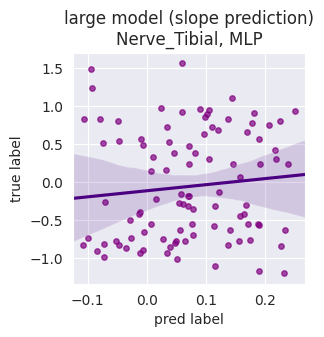

In [12]:
from sklearn.neural_network import MLPRegressor
ml_model = model_list[0]
mlp = MLPRegressor(max_iter=1000, early_stopping=True, learning_rate_init=0.001, hidden_layer_sizes=(1024, 512, 128))

mlp.fit(X_train,Y_train)

y_pred = mlp.predict(X_test)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:cnn

rmse= 0.7432880793297691
r2= -0.10747780082844915
pcc= 0.16991237564652345
pcc_p= 0.09613819279866818


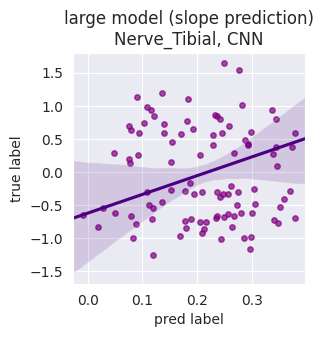

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


def build_model(n_layers=1, kernel_size=3, strides=1, filters=16, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(1024, 1)))
    model.add(layers.MaxPool1D(2, padding='same'))
    if n_layers == 2:
        # 如果有两层，添加第二层卷积层
        model.add(layers.Conv1D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'))
        model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

    return model

X_train_reshape = np.expand_dims(X_train, axis=-1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ml_model = model_list[1]
# cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=5, strides=1, filters=16, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)
cnn = KerasRegressor(model=build_model, n_layers=2, kernel_size=3, strides=1, filters=16,learning_rate=0.001, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

cnn.fit(X_train_reshape, Y_train, batch_size=16, callbacks=[early_stopping])

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_pred = cnn.predict(X_test_reshape)                                   

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

print('rmse=',rmse)
print('r2=',r2)
print('pcc=',pcc)
print('pcc_p=',pcc_p)

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: rnn

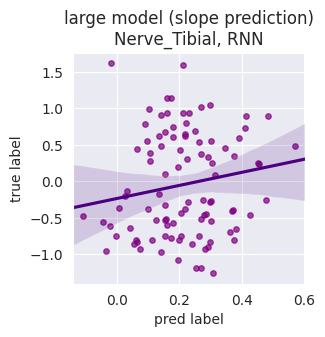

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def build_model(units, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.SimpleRNN(units=units, return_sequences=True, input_shape=(1024, 1)))
    model.add(layers.Flatten(input_shape=(1024, units)))
    model.add(layers.Dense(1))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
    return model

ml_model = model_list[2]

# 早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 定义模型
rnn = KerasRegressor(model=build_model, units=8, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

X_train_reshape = np.expand_dims(X_train, axis=-1)

# 执行网格搜索
rnn.fit(X_train_reshape,Y_train, verbose=0)

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_pred = rnn.predict(X_test_reshape)

rmse = np.sqrt(mean_squared_error(Y_test, y_pred))
r2 = r2_score(Y_test, y_pred)
pcc = pearsonr(Y_test, y_pred)[0]
pcc_p = pearsonr(Y_test, y_pred)[1]

ax = plt.subplots(figsize=(3,3))
plt.ylabel("true label")
plt.xlabel("pred label")
sns.regplot(x=y_pred,y=Y_test,x_jitter = 0.15,y_jitter = 0.15,
            scatter_kws = {'color':'#800080','alpha':0.7,'s':15}, line_kws={"color": "#4B0082"},truncate=False)
plt.title('large model (slope prediction)\n' + tissue + ', ' + ml_model)

plt.savefig(image_path + 'cm-large-slope-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()